# Spark Project
## Explore the Stack Overflow User Behavior and Predict Question Popularity

## Background: 
Stack Overflow is a collaboratively edited question-and-answer site originally focused on programming topics. There are a variety of features tracked, including a variety of feedback metrics, such as: 
* Title
* Favorite counts
* View counts
* Answer counts
* Score
* Question tag
* etc.

The project focuses on the analysis of user behavior on the site.  Stack Exchange provides anonymized data, and I used Spark to perform data manipulation, analysis, and machine learning on the post and user data set.

## Data:
There are two sets of data used in the project: 
A small dataset for xml parsing and Spark pipeline test 
* 108741 Posts
* 50320 User Accounts

The full dataset for exploratory analysis
* Posts
* User Accounts

### Accessing the data


In [7]:
!aws s3 cp s3://dataincubator-course/spark-stats-data/stack_exchange_schema.txt .

download: s3://dataincubator-course/spark-stats-data/stack_exchange_schema.txt to ./stack_exchange_schema.txt


In [1]:
!mkdir -p spark-stats-data ## sample test data
!aws s3 sync --exclude '*' --include 'all*' s3://dataincubator-course/spark-stats-data/ ./spark-stats-data
!aws s3 sync --exclude '*' --include 'posts*zip' s3://dataincubator-course/spark-stats-data/ ./spark-stats-data

In [ ]:
!mkdir -p spark-stack-data ## full data
!aws s3 sync --exclude '*' --include 'all*' s3://dataincubator-course/spark-stack-data/ ./spark-stack-data

## Analysis

### Import packages

In [74]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [22]:
import os, time
from lxml import etree
import datetime as dt
import numpy as np

In [7]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [224]:
import gc
gc.collect()

0

In [11]:
sc = SparkContext("local[*]","mini project")
spark = SparkSession(sc)

In [12]:
sc.stop()

### Data parsing functions

* Some rows are split across multiple lines; these were discarded. Incorrectly formatted XML can also be ignored. 

* Use `lxml.etree` for parsing (UTF-8 encode)

In [31]:
def xml_filter(rdd):  ## xml filter to keep only <row />
    new_rdd = rdd.filter(lambda s:'<row' in s and '/>' in s)
    return new_rdd

In [32]:
def get_attr(x, y): ## helper function to deal with None attriutes in the post
    '''
    if x is None, y is the alternative
    '''
    if x:
        return x
    else:
        return y

In [33]:
def convert_time(string):
    t = dt.datetime.strptime(string,"%Y-%m-%dT%H:%M:%S.%f")
    return t

In [34]:
from datetime import datetime
from lxml import etree
def post_parse(xml_string):
    d = dict()
    root = etree.fromstring(xml_string.encode('UTF-8', errors='replace'))
    
    d['Title'] = get_attr(root.get('Title'),-9999)
    d["FavoriteCount"] = int(get_attr(root.get("FavoriteCount"),0))
    d["Score"] = int(get_attr(root.get("Score"),0))
    d["AnswerCount"] = int(get_attr(root.get('AnswerCount'),0))
    d["CommentCount"] = int(get_attr(root.get('CommentCount'),0))
    d["ViewCount"] = int(get_attr(root.get('ViewCount'),0))
    d["LastEditorUserId"] = int(get_attr(root.get('LastEditorUserId'),-9999))
    d["OwnerUserId"] = int(get_attr(root.get('OwnerUserId'),-9999))
    d["PostTypeId"] = int(get_attr(root.get('PostTypeId'),-9999))
    d["CreationDate"] = convert_time(get_attr(root.get('CreationDate'),'9000-01-01T01:01:01.001'))
    d["Tags"] = get_attr(root.get('Tags'),'Notag').strip('<').strip('>').split('><')
    d['Body'] = get_attr(root.get('Body'),'Nobody')
    d["Id"] = int(get_attr(root.get('Id'),-9999))
    return d

def user_parse(xml_string):
    d = dict()
    root = etree.fromstring(xml_string.encode('UTF-8', errors='replace'))
    
    d["UserId"] = int(get_attr(root.get('Id'),-9999))
    d["Reputation"] = int(get_attr(root.get("Reputation"),-9999))
    d["CreationDate"] = convert_time(get_attr(root.get('CreationDate'),'9000-01-01T01:01:01.001'))
  
    return d

def get_date(xml_string):
    root = etree.fromstring(xml_string.encode('UTF-8', errors='replace'))
    date = root.get('CreationDate')
    return date

def get_body(xml_string):
    
    root = etree.fromstring(xml_string.encode('UTF-8', errors='replace'))
    x = get_attr(root.get('Body'),'Nobody')
    soup = BeautifulSoup(x,'lxml')
    y = re.sub(r'[%#,\n,\\]', ' ',soup.get_text())

    return y

def get_tag(xml_string):
    root = etree.fromstring(xml_string.encode('UTF-8', errors='replace'))
    x = get_attr(root.get('Tags'),'NoTag')
    return x.strip('<').strip('>').split('><')

In [17]:
## could build a class for parsing
class Parse_xml(object):
    def __init__(self, xml_string,d):
        self.xml_string = xml_string
        self.root = etree.fromstring(xml_string.encode('UTF-8', errors='replace'))
        self.d = dict()
    @classmethod
    def post_parse(xml_string):

        d['Title'] = get_attr(root.get('Title'),-9999)
        d["FavoriteCount"] = int(get_attr(root.get("FavoriteCount"),0))
        d["Score"] = int(get_attr(root.get("Score"),0))
        d["AnswerCount"] = int(get_attr(root.get('AnswerCount'),0))
        d["CommentCount"] = int(get_attr(root.get('CommentCount'),0))
        d["ViewCount"] = int(get_attr(root.get('ViewCount'),0))
        d["LastEditorUserId"] = int(get_attr(root.get('LastEditorUserId'),-9999))
        d["OwnerUserId"] = int(get_attr(root.get('OwnerUserId'),-9999))
        d["PostTypeId"] = int(get_attr(root.get('PostTypeId'),-9999))
        d["CreationDate"] = convert_time(get_attr(root.get('CreationDate'),'9000-01-01T01:01:01.001'))
        d["Tags"] = get_attr(root.get('Tags'),'Notag').strip('<').strip('>').split('><')
        d['Body'] = get_attr(root.get('Body'),'Nobody')
        d["Id"] = int(get_attr(root.get('Id'),-9999))
        
        return cls(d)

    def user_parse(xml_string):
        d = dict()

        d["UserId"] = int(get_attr(root.get('Id'),-9999))
        d["Reputation"] = int(get_attr(root.get("Reputation"),-9999))
        d["CreationDate"] = convert_time(get_attr(root.get('CreationDate'),'9000-01-01T01:01:01.001'))

        return cls(d)
    
    def get_tag(xml_string):
        x = get_attr(root.get('Tags'),'NoTag').strip('<').strip('>').split('><')
        
        return cls(x)
    
    def get_body(xml_string):
    
        root = etree.fromstring(xml_string.encode('UTF-8', errors='replace'))
        x = get_attr(root.get('Body'),'Nobody')
        soup = BeautifulSoup(x,'lxml')
        y = re.sub(r'[%#,\n,\\]', ' ',soup.get_text())
        
        return cls(y)

### 1. Explorary Analysis

### 1). Post of high reputation users

Investigate the correlation between a user's reputation and the kind of posts they make. 
For the 99 users with the highest reputation, look at the percentage of these posts that are answers: *(answers / (answers + questions))*. 

In [18]:
post_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stats-data/allPosts')
post_rdd = xml_filter(post_rdd)
user_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stats-data/allUsers')
user_rdd = xml_filter(user_rdd)

In [23]:
user_rep = user_rdd.map(lambda x: user_parse(x)).sortBy(lambda x: x[1],ascending=False)

[(919, 100976, datetime.datetime(2010, 8, 13, 15, 29, 47, 140000)),
 (805, 92624, datetime.datetime(2010, 8, 7, 8, 40, 7, 287000)),
 (686, 47334, datetime.datetime(2010, 8, 3, 19, 42, 40, 907000))]

In [36]:
post_dict = post_rdd.map(lambda x:post_parse(x))

In [37]:
post_type = post_dict.map(lambda x: (x['OwnerUserId'],x['PostTypeId']))

In [38]:
ques_rdd = post_type.filter(lambda x: x[1] == 1)
ans_rdd = post_type.filter(lambda x: x[1] == 2)

In [39]:
ques_rdd.take(5),ans_rdd.take(5)

([(198, 1), (20010, 1), (12329, 1), (7667, 1), (11233, 1)],
 [(2111, 2), (18274, 2), (858, 2), (16974, 2), (20014, 2)])

In [41]:
ques_rdd_aggre = ques_rdd.map(lambda x: (x[0],1)).reduceByKey(lambda x, y: x + y)
ans_rdd_aggre = ans_rdd.map(lambda x: (x[0],1)).reduceByKey(lambda x, y: x + y)

In [42]:
ques_rdd_aggre.take(3),ans_rdd_aggre.take(3)

([(198, 7), (7667, 7), (20031, 1)], [(858, 107), (6633, 226), (6248, 56)])

In [43]:
ans_rdd_aggre.map(lambda x:x[1]).sum(),ques_rdd_aggre.map(lambda x:x[1]).sum()

(55304, 52060)

In [206]:
ans_ques= ans_rdd_aggre.fullOuterJoin(ques_rdd_aggre)

In [48]:
## question and answer aggregation
ques_rdd_aggre = post_rdd.map(lambda x:post_parse(x)) \
                   .map(lambda x: (x['OwnerUserId'],x['PostTypeId'])) \
                   .filter(lambda x: x[1] == 1).map(lambda x: (x[0],1)) \
                   .reduceByKey(lambda x, y: x + y).cache()

ans_rdd_aggre = post_rdd.map(lambda x:post_parse(x)) \
                   .map(lambda x: (x['OwnerUserId'],x['PostTypeId'])) \
                   .filter(lambda x: x[1] == 2) \
                   .map(lambda x: (x[0],1)) \
                   .reduceByKey(lambda x, y: x + y).cache()

ans_ques = ans_rdd_aggre.fullOuterJoin(ques_rdd_aggre)

In [50]:
user_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stats-data/allUsers')
user_rdd = xml_filter(user_rdd)

In [61]:
user_rep = user_rdd.map(lambda x: user_parse(x)) \
                   .map(lambda x: (x['UserId'],x["Reputation"])) \
                   .sortBy(lambda x: x[1],ascending=False).cache()

In [63]:
import pandas as pd

In [64]:
df_user = pd.DataFrame(user_rep.collect(),columns = ['user','rep'])

In [65]:
df_ans_ques = pd.DataFrame(ans_ques.map(lambda x: (x[0],*x[1])).collect(),columns = ['user','n_ans','n_ques'])
df_ans_ques = df_ans_ques.fillna(0)
df_ans_ques['ans_ratio'] = df_ans_ques['n_ans']/(df_ans_ques['n_ans']+df_ans_ques['n_ques'])

In [79]:
df_user_post = df_user.merge(df_ans_ques,on='user',how = 'left')
df_user_post[0:5]

,user,rep,n_ans,n_ques,ans_ratio
0,919,100976,1206.0,4.0,0.996694
1,805,92624,2227.0,9.0,0.995975
2,686,47334,1543.0,31.0,0.980305
3,7290,46907,856.0,7.0,0.991889
4,930,32283,430.0,8.0,0.981735


Text(0.5,0.98,'Answer-question ratio vs reputation')

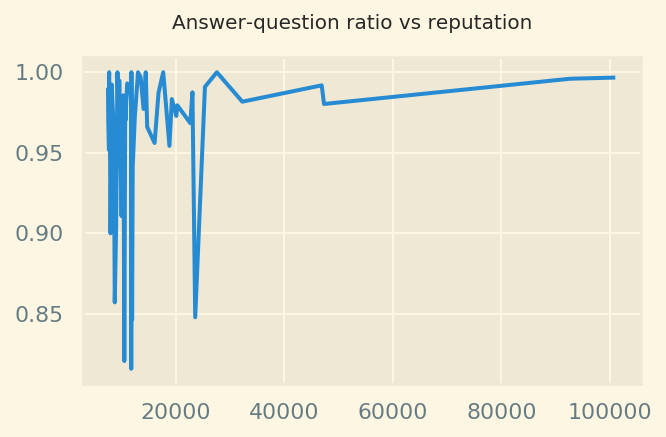

In [136]:
# plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(df_user_post[0:50]['rep'],df_user_post[0:50]['ans_ratio'])
# plt.title('Answer-question ratio vs reputation')
fig.suptitle('Answer-question ratio vs reputation', fontsize=10)

### 2). Identify veterans and brief users - sample test data


What factors influence a user to remain active on the site over a long period of time?

A time window between 100 and 150 days after account creation was defined a active user of the website. 

If the user has made a post in this time, we consider them active and well on their way to being veterans of the site; if not, they are inactive and were likely brief users.

#### Pyspark DataFrame solution

In [88]:
post_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stats-data/allPosts')
user_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stats-data/allUsers')
post_rdd = xml_filter(post_rdd)
user_rdd = xml_filter(user_rdd)

In [89]:
post_date = post_rdd.map(lambda x:post_parse(x)).map(lambda x: (x['OwnerUserId'],x['CreationDate']))
all_user = user_rdd.map(lambda x: user_parse(x)).map(lambda x: (x['UserId'],x['CreationDate']))

In [90]:
post_user = all_user.rightOuterJoin(post_date)

In [91]:
vet = post_user.filter(lambda x: x[1][0]!=None) \
               .map(lambda x: (x[0],(x[1][1]-x[1][0]).days)) \
               .filter(lambda x: x[1]!=None) \
               .filter(lambda x: (x[1]>=100) and (x[1]<150)) \
               .reduceByKey(lambda x, y: (x if (x < y) else y)) \
               .map(lambda x: (x[0],1)).cache()

In [92]:
hasattr(vet, "toDF")

True

In [93]:
df_vet = vet.toDF(['userid','vet']).cache()

In [95]:
first_q = post_rdd.map(lambda x:post_parse(x)) \
                  .filter(lambda x: x['PostTypeId']==1) \
                  .map(lambda x: (x['OwnerUserId'],
                                      (x['CreationDate'],x['Score'],x['ViewCount'],x['AnswerCount'],x['FavoriteCount']))) \
                  .reduceByKey(lambda x, y: (x if (x[0] < y[0]) else y)) \
                  .map(lambda x: (x[0],*x[1])).cache()

In [96]:
hasattr(first_q, "toDF")

True

In [97]:
df_fq= first_q.toDF(['userid','postdate','score','view','answer','favorite'])

In [100]:
df_fq_cat = df_fq.join(df_vet,on = 'userid',how = 'left')
df_fq_cat = df_fq_cat.na.fill(0)

In [101]:
df_fq_cat.groupBy('vet').mean('score','view','answer','favorite').collect()

[Row(vet=0, avg(score)=2.1085569525239256, avg(view)=557.6710452242447, avg(answer)=0.9730718708951023, avg(favorite)=0.5793300806905611),
 Row(vet=1, avg(score)=3.5434543454345433, avg(view)=926.3982398239824, avg(answer)=1.2981298129812981, avg(favorite)=1.300880088008801)]

In [143]:
df_vb_mean = df_fq_cat.groupBy('vet').mean('score','view','answer','favorite').toPandas()
df_vb_mean = df_vb_mean.set_index('vet').transpose()

In [169]:
df_vb_mean

vet,0,1
avg(score),2.108557,3.543454
avg(view),557.671045,926.398240
avg(answer),0.973072,1.298130
avg(favorite),0.579330,1.300880


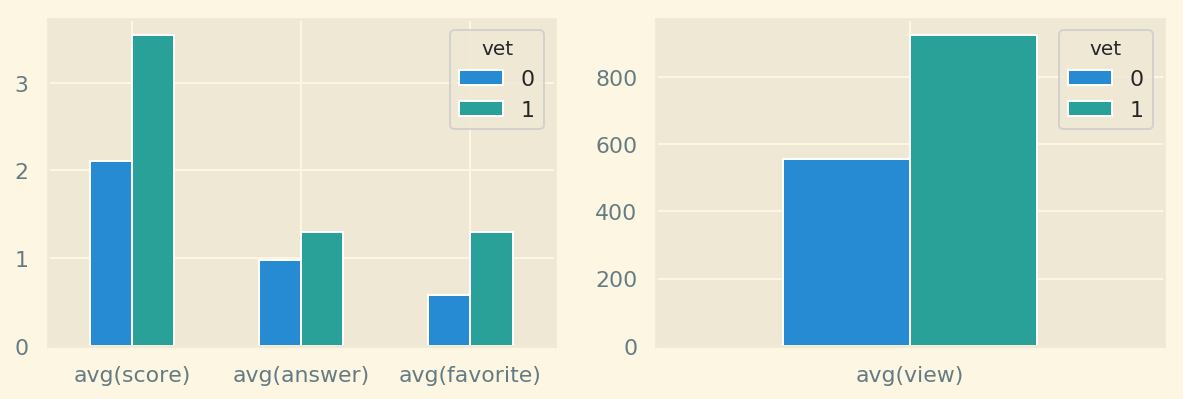

In [199]:
fig, axes = plt.subplots(nrows=1, ncols = 2,figsize=(10,3))
df_vb_mean.loc[['avg(score)','avg(answer)','avg(favorite)']].plot.bar(rot=0,ax=axes[0])
df_vb_mean.loc[['avg(view)']].plot.bar(rot=0,ax=axes[1])

### 3). Identify veterans and brief users - full data


* Total brief users: 1,848,628
* Total veteran users: 288,285

### Dataframe solution

In [21]:
post_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stack-data/allPosts')
user_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stack-data/allUsers')

In [22]:
post_rdd = xml_filter(post_rdd)
user_rdd = xml_filter(user_rdd)

In [23]:
post_date = post_rdd.map(lambda x:post_parse(x)).map(lambda x: (x['OwnerUserId'],x['CreationDate']))
all_user = user_rdd.map(lambda x: user_parse(x)).map(lambda x: (x['UserId'],x['CreationDate']))

In [26]:
post_user = all_user.rightOuterJoin(post_date)

In [27]:
vet = post_user.filter(lambda x: x[1][0]!=None) \
               .map(lambda x: (x[0],(x[1][1]-x[1][0]).days)) \
               .filter(lambda x: x[1]!=None) \
               .filter(lambda x: (x[1]>=100) and (x[1]<150)) \
               .reduceByKey(lambda x, y: (x if (x < y) else y)) \
               .map(lambda x: (x[0],1))

In [239]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [28]:
hasattr(vet, "toDF")

True

In [29]:
df_vet = vet.toDF(['userid','vet']).cache()

In [33]:
first_q = post_rdd.map(lambda x:post_parse(x)) \
                  .filter(lambda x: x['PostTypeId']==1) \
                  .map(lambda x: (x['OwnerUserId'],
                                      (x['CreationDate'],x['Score'],x['ViewCount'],x['AnswerCount'],x['FavoriteCount']))) \
                  .reduceByKey(lambda x, y: (x if (x[0] < y[0]) else y)) \
                  .map(lambda x: (x[0],x[1][0],x[1][1],x[1][2],x[1][3],x[1][4]))

In [34]:
hasattr(first_q, "toDF")

True

In [35]:
df_fq= first_q.toDF(['userid','postdate','score','view','answer','favorite']).cache()

In [41]:
df_fq_cat = df_fq.join(df_vet,on = 'userid',how = 'left')

In [43]:
df_fq_cat.cache()
df_fq_cat = df_fq_cat.na.fill(0)

DataFrame[userid: bigint, postdate: timestamp, score: bigint, view: bigint, answer: bigint, favorite: bigint, vet: bigint]

In [44]:
df_fq_cat.groupBy('vet').mean('score','view','answer','favorite').collect()

[Row(vet=0, avg(score)=1.1422597806491668, avg(view)=1103.6014704081429, avg(answer)=1.506747558575672, avg(favorite)=0.3918475366462847),
 Row(vet=1, avg(score)=2.2598437331442924, avg(view)=1844.0344896669696, avg(answer)=1.8426197044183144, avg(favorite)=0.8673157237744455)]

In [ ]:
[Row(vet=0, avg(score)=1.1422597806491668, avg(view)=1103.6014704081429, avg(answer)=1.506747558575672, avg(favorite)=0.3918475366462847),
 Row(vet=1, avg(score)=2.2598437331442924, avg(view)=1844.0344896669696, avg(answer)=1.8426197044183144, avg(favorite)=0.8673157237744455)]

### 4). Word2vec Model for synonyms similarity


Word2Vec is an alternative approach for vectorizing text data. The vectorized representations of words in the vocabulary tend to be useful for predicting other words in the document, hence the famous example "vector('king') - vector('man') + vector('woman') ~= vector('queen')".

Train a Word2Vec model using the tags of each Stack Exchange post as documents. Used the implementation of Word2Vec from Spark ML  to return a list of the top 25 closest synonyms to "ggplot2" and their similarity score.

The dimensionality of the vector space set to be 100.

In [200]:
from pyspark.ml.feature import Word2Vec

In [201]:
post_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stack-data/allPosts')
post_rdd = xml_filter(post_rdd)

In [8]:
post_rdd.count()

24081922

In [202]:
df_tag = post_rdd.map(lambda x: (get_tag(x),1)).toDF(['text', 'score']).cache()

In [203]:
w2v = Word2Vec(inputCol="text", outputCol="vectors", vectorSize=100, seed=42)
model = w2v.fit(df_tag)

In [300]:
# result = model.transform(df_tag)

In [204]:
vectors = model.getVectors().rdd.map(lambda x: (x.word, x.vector))

In [205]:
## Find the top 25 words similar to ggplot2 using Word2vec model
ggplot_syn = model.findSynonyms('ggplot2', 25).rdd.map(lambda x: (x[0],x[1])).collect()

In [208]:
ggplot_syn

[('lattice', 0.8981772065162659),
 ('r-grid', 0.8513233661651611),
 ('plotrix', 0.847938060760498),
 ('boxplot', 0.8321753144264221),
 ('ecdf', 0.831939697265625),
 ('tapply', 0.8171764612197876),
 ('levelplot', 0.8164395689964294),
 ('line-plot', 0.8150685429573059),
 ('bwplot', 0.8137515187263489),
 ('quantile', 0.8122984170913696),
 ('gridextra', 0.8112598061561584),
 ('rgl', 0.8111367225646973),
 ('categorical-data', 0.8052302598953247),
 ('plotmath', 0.8047652840614319),
 ('standard-error', 0.8035489916801453),
 ('melt', 0.8027551174163818),
 ('r-factor', 0.8002736568450928),
 ('tidyr', 0.7998123168945312),
 ('density-plot', 0.7993367910385132),
 ('anova', 0.7988731861114502),
 ('geom-text', 0.797473669052124),
 ('gmisc', 0.7968437671661377),
 ('confidence-interval', 0.795746922492981),
 ('lm', 0.7955560088157654),
 ('trellis', 0.7951833605766296)]

## 2. Classification


This problem focus on predict the tags of a question from its body text. Instead of predicting specific tags, we try to predict if a question contains one of the top ten most common tags. 

Train and a test set from the original data. 
  * s3://dataincubator-course/spark-stats-data/posts_train.zip
  * s3://dataincubator-course/spark-stats-data/posts_test.zip
  * s3://dataincubator-course/spark-stats-data/posts_test_tagged.zip

The solution involves in two steps: 
first, find the ten most common tags for questions in the training data set. 
Second, train a learner to predict from the text of the question (the `Body` attribute) if it should have one of those ten tags in it. (Process the question text with NLP techniques such as tokenization.)

The predictions are `0` if the question isn't expected to have a top ten popular tag, and `1` if it is.

In [216]:
!unzip -d spark-stats-data/train spark-stats-data/posts_train.zip
!unzip -d spark-stats-data/test spark-stats-data/posts_test_tagged.zip

In [217]:
from bs4 import BeautifulSoup
import re

In [218]:
train_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stats-data/train')
train_rdd=xml_filter(train_rdd)

In [219]:
## fetch the top 10 tags
top_tag_list = train_rdd.filter(lambda x: post_parse(x)['PostTypeId']==1) \
         .flatMap(lambda x: (get_tag(x))).filter(lambda x: 'NoTag' not in x) \
         .map(lambda x:(x,1)) \
         .reduceByKey(lambda x,y: x+y) \
         .sortBy(lambda x: x[1],ascending=False).take(10)

In [220]:
top_tag = []
for item in top_tag_list:
    top_tag.append(item[0])
top_tag

['r',
 'regression',
 'time-series',
 'machine-learning',
 'probability',
 'hypothesis-testing',
 'distributions',
 'self-study',
 'logistic',
 'correlation']

In [221]:
def label_popular(tags_list): ## helper function to label top 10 tags or not
    for item in tags_list:
        if item in top_tag:
            return 1
        else:
            return 0

In [222]:
hasattr(train_rdd, "toDF")

True

### Model pipeline

In [225]:
from pyspark.ml.classification import RandomForestClassifier,NaiveBayes,LogisticRegression,OneVsRest,DecisionTreeClassifier
from pyspark.ml.feature import Tokenizer,HashingTF, CountVectorizer,IDF,StopWordsRemover,RegexTokenizer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [143]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
from spacy.lang.en.stop_words import STOP_WORDS

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [226]:
df_train = train_rdd.filter(lambda x: post_parse(x)['PostTypeId']==1) \
                    .map(lambda x: (post_parse(x)['Id'],get_body(x),label_popular(get_tag(x)))) \
                    .toDF(['id','body_text', 'label']).cache()

In [227]:
## Regex tokenize body text
regToken = RegexTokenizer(inputCol='body_text',outputCol= 'raw_words')

In [228]:
## Set and remove stop words (not used any stopword in the final model pipeline)
stopRemove = StopWordsRemover(inputCol='raw_words',outputCol= 'words',stopWords=[])

In [229]:
## Vectorized the words opt1
hashingTF = HashingTF(inputCol='words', outputCol="rawfeatures",numFeatures = 65536)

In [230]:
## Vectorized the words opt2
countVec = CountVectorizer(inputCol='words', outputCol="rawfeatures",minDF = 0.01,maxDF=0.99)

In [231]:
## TFIDF
tfidf = IDF(inputCol='rawfeatures', outputCol="features")

In [279]:
## logistic regression
logreg = LogisticRegression(regParam=0.01) # best regParam = 0.001

In [233]:
## Pyspark grid search
## logistic grid search
paramGrid = (ParamGridBuilder() 
#     .addGrid(hashingTF.numFeatures, [1000,2000,3000]) 
    .addGrid(logreg.regParam, [0.001,0.01,1,10]) 
    .build())
## RF grid search
# paramGrid = (ParamGridBuilder() 
#     .addGrid(hashingTF.numFeatures, [1000,2000,3000]) 
#     .addGrid(rf.numTrees, [20,50]) 
#     .build())

In [415]:
## alternative classifier
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')
ovr = OneVsRest(featuresCol = 'features', labelCol = 'label',classifier=logreg)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',numTrees=50)

In [280]:
## Model pipeline
pipeline = Pipeline(stages=[regToken,stopRemove,countVec,tfidf,logreg])

### Cross validation for parameter selection


In [235]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [ ]:
## Cross Validation
cvModel = crossval.fit(df_train)

In [277]:
cvModel.avgMetrics ## Metrics: areaunderROC

[0.7387147917239714, 0.739296975368692, 0.7306034167058599, 0.71170079146182]

In [291]:
zip(cvModel.avgMetrics, paramGrid)

In [278]:
cvModel.bestModel.stages[4].extractParamMap()

{Param(parent='LogisticRegression_70dd6d4f6976', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_70dd6d4f6976', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_70dd6d4f6976', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_70dd6d4f6976', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_70dd6d4f6976', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_70dd6d4f6976', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_70dd6d4f6976', name='maxIter', doc='maximum number of iterations (>= 0)'): 

### Model fit

In [281]:
## model fit
start = datetime.now()

pipe_model = pipeline.fit(df_train)

end = datetime.now()
print('It takes: ' + str(end-start))

It takes: 0:00:41.561004


### Predict test data

In [260]:
test_rdd = sc.textFile('/home/jovyan/datacourse/spark.new/miniprojects/spark-stats-data/test')
test_rdd = xml_filter(test_rdd)

In [264]:
df_test = test_rdd.filter(lambda x: post_parse(x)['PostTypeId']==1) \
                    .map(lambda x: (post_parse(x)['Id'],get_body(x),label_popular(get_tag(x)))) \
                    .toDF(['id','body_text', 'label']).cache()

In [265]:
prediction = cvModel.transform(df_test)
# prediction = pipe_model.transform(df_test)

In [266]:
prediction = prediction.sort('id')

### Test validation

In [311]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [316]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderROC')

In [317]:
evaluator.evaluate(prediction)

0.7491933968814067

*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*